# The Kyle Model

In [15]:
import pickle
import numpy as np
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

The first thing to do is import the raw data - make sure you don't try to print any of this or jupyter *will* crash! Also make sure you manually save the data as a txt file.

In [3]:
AAPLraw = pickle.load(open('AAPL.txt', 'rb'))
Craw = pickle.load(open('C.txt', 'rb'))
GBXraw = pickle.load(open('GBX.txt', 'rb'))
SPYraw = pickle.load(open('SPY.txt', 'rb'))
THOraw = pickle.load(open('THO.txt', 'rb'))

## Part 1

In [20]:
class Orderbook:
    '''
    The orderbook class. Initialized with a single element of the raw data files.
    Methods:
        __init__: accepts the raw data and cleans it up - the final form is a dataframe
            with columns for price, quantity at that price, cumulative quantity, and 
            buy/sell side.
        estimate: estimates parameters γ and β for equation (10). Default is to use a 
            subset of the data only inculding bids within .05 pct of the market price
        plot: plots the orderbook within a user-specified window (default within .05 
            percent of market price)
    '''
    
    def __init__(self, data):
        self.time = data[0]
        
        #Cleaning
        df = pd.DataFrame.from_dict(data[1], orient='index')
        df = df.sort_index()
        df = df.reset_index()
        df.columns = ['Price', 'Quantity', 'Side', 'X','Y']
        df = df.drop(['X', 'Y'], axis = 1)
        
        #Get cumulative quantity - setting 0 to where buy meets sell
        df['Cumulative_Quantity'] = df['Quantity'].cumsum()
        Qmkt = np.max(df['Cumulative_Quantity'][df['Side']== 'B'])
        Pmkt = df['Price'][(df['Cumulative_Quantity'][df['Side']== 'B']).idxmax()]
        df['Cumulative_Quantity'] = df['Cumulative_Quantity'] - Qmkt
        # Save Price as attribute
        self.Pmkt = Pmkt
        
        #Restrict to region where most of the quantity moves
        
        #Save data and some subsets as attributes
        self.data = df
        self.data50 = df[(df.Price <= df.Price.quantile(.75)) 
                               & (df.Price >= df.Price.quantile(.25))]
        
    '''     
    def estimate(self, lb = 'default', ub = 'default'):
        #thanks natasha for showing me OLS estimators
        if lb == 'default':
            lb = self.Pmkt*.95
        if ub == 'default':
            ub = self.Pmkt*1.05
        restricted = self.data[(self.data['Price']>lb) & (self.data['Price']<ub)]
        self.data['constant'] = 1
        y = self.data['Cumulative Quantity']
        X = self.data[['constant', 'Price']]
        print('look here mate \n',np.linalg.lstsq(X, y, rcond=None))
        gamma, beta = np.linalg.lstsq(X, y, rcond=None)[0]
        self.gamma = gamma
        self.beta = beta
        return gamma, beta
    '''
    def estimate(self, orderbook):
        result = smf.ols(formula='Cumulative_Quantity ~ Price', data=orderbook)
        return result
    
    def plot(self, lb = 'default', ub = 'default'):
        if lb == 'default':
            lb = self.Pmkt*.95
        if ub == 'default':
            ub = self.Pmkt*1.05
        restricted = self.data[(self.data['Price']>lb) & \
                               (self.data['Price']<ub)]
        plt.plot(restricted['Price'], restricted['Cumulative_Quantity'],\
                 label = 'Orderbook data')
        #Save the Pgrid in self for future plotting
        self.Pgrid = np.linspace(lb, ub, 300)
        plt.plot(self.Pgrid, self.gamma + self.beta * self.Pgrid , \
                label = 'Linear approximation')
        plt.legend(loc = 'center left', bbox_to_anchor = (.5, 1))
        
        

In [21]:
Testbook = Orderbook(AAPLraw[0])
#Testbook.plot()
gamma, beta = Testbook.estimate(Testbook.data50)
fig = plt.subplots(figsize = (12, 7))
Testbook.plot(lb = 78, ub = 200)
gamma, beta
Testbook.data

TypeError: 'OLS' object is not iterable

In [185]:
class Assetday():
    '''
    This class is initialized with a raw data dictionary from the NASDAQ ITCH files,
    cleans the data into individual data-frames and is equipped with some nice plotting 
    methods which span the whole day.
    '''
    
    def __init__(self, rawdata):
        #Initialize attributes
        self.price = []
        self.times = []
        for i in range(len(rawdata)):
            book = Orderbook(rawdata[i])
            self.price.append(book.Pmkt)
            self.times.append(book.time)
        

In [192]:
SPYAD = Assetday(Craw)

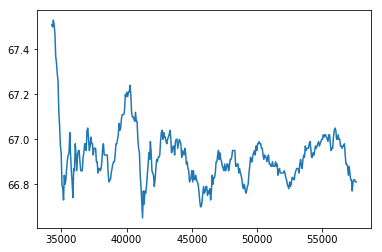

In [193]:
plt.plot(SPYAD.times, SPYAD.price)

In [118]:
#SCOTT
class OrderBook(object):
    def __init__(self, ob_data):
        '''This class represents an order book at any point in time.  The time stamp of the orderbok is saved as an attribute of the dataframe df.timestamp'''
        data_list = []
        for ii in ob_data[1].items():
            data_list.append((ii[0],ii[1][0], ii[1][1]))

        df = pd.DataFrame.from_records(data_list, columns=["P","Q","S"])
        df.timestamp = ob_data[0]
        df = df.sort_values(by=["P"])
        self.df = df
        
        # Now make the orderbook cumulative.
        #Bid side first
        df_bids = df[df['S'] == "B"]

        df_bids = df_bids.sort_values(by="P", ascending=False)
        df_bids['tot_y'] = df_bids['Q'].cumsum()
        #print(df_bids)

        # Now ask side
        df_asks = df[df['S'] == 'S']
        df_asks = df_asks.sort_values(by="P", ascending=True)
        # Note that when y is negative, the buy side of the orderbook will be used (since liq. demanders want to sell)
        df_asks['tot_y'] = -df_asks['Q'].cumsum()
        self.df = pd.concat([df_bids, df_asks], axis=0)

        self.df['y'] = self.df['tot_y']
        self.df = self.df.drop('tot_y', axis=1)
        

In [119]:
scottbook = OrderBook(AAPLraw[100])
scottbook.df
#restrictbook
#plt.plot(scottbook.df['y'])

,P,Q,S,y
202,67.24,2979,B,2979
466,67.23,14746,B,17725
498,67.22,18508,B,36233
326,67.21,22713,B,58946
461,67.20,13426,B,72372
520,67.19,6078,B,78450
371,67.18,3365,B,81815
238,67.17,3457,B,85272
125,67.16,4833,B,90105
370,67.15,4756,B,94861


In [43]:
print(SPYraw[0:2])

[(34260, {242.25: (10200, 'S', 34255.0261388, 7253328.0), 237.5: (302, 'B', 34202.9575079, 6292224.0), 2.0: (1, 'B', 28802.643090400004, 2535176.0), 244.61: (100, 'S', 34203.8539523, 6340504.0), 138.5: (800, 'B', 34203.017149, 6299972.0), 1.0: (2, 'B', 34202.2114565, 6207704.0), 228.82: (35, 'B', 34203.0132075, 6299204.0), 0.0: (100, 'B', 33900.7280436, 5144916.0), 234.56: (18, 'B', 34203.0208038, 6300668.0), 202.77: (160, 'B', 34203.0051707, 6297588.0), 224.77: (198, 'B', 34203.023326300005, 6301184.0), 224.5: (28, 'B', 34203.0137441, 6299340.0), 224.31: (10, 'B', 34203.0146368, 6299528.0), 232.51: (15, 'B', 34202.219410000005, 6208576.0), 210.15: (150, 'B', 34203.0247543, 6301432.0), 193.74: (1000, 'B', 34200.4424056, 5170116.0), 239.78: (7, 'B', 34203.0228139, 6301100.0), 241.72: (100, 'B', 23401.199621, 1383196.0), 210.81: (250, 'B', 34203.0160233, 6299792.0), 234.75: (30, 'B', 34202.2137875, 6207852.0), 243.88: (40, 'S', 34203.019047, 6300340.0), 243.64: (0, 'S', 34199.2986275, 58